## Dependencies

In [1]:
import re
import warnings
from joblib import dump
import tensorflow_hub as hub
from tensorflow.keras import Model, optimizers
from tensorflow.keras.layers import Lambda, Input, Dense, Dropout, Concatenate, BatchNormalization, Activation, Average, Add, Reshape, GlobalAveragePooling1D, LSTM, GRU
from tensorflow.keras.callbacks import ReduceLROnPlateau
from googleqa_utilityscript import *


SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

## Load data

In [2]:
module_url = '/kaggle/input/universalsentenceencodermodels/universal-sentence-encoder-models/use'
model_path = '/kaggle/working/use.h5'

hold_out = pd.read_csv('/kaggle/input/googleqa-mldataset/hold-out.csv')
train = hold_out[hold_out['set'] == 'train']
validation = hold_out[hold_out['set'] == 'validation']

print('Train samples: %s' % len(train))
print('Validation samples: %s' % len(validation))
display(train.head())

Train samples: 4863
Validation samples: 1216


,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written,set
0,3895,Magento (1.7) Bundled Product with FREE Produc...,I'm looking to create a bundle offer where cus...,Joe,https://magento.stackexchange.com/users/16572,"Since the third item is fixed, you can use sho...",Fabian Schmengler,https://magento.stackexchange.com/users/243,http://magento.stackexchange.com/questions/668...,TECHNOLOGY,...,0.888889,0.666667,1.0,1.0,0.933333,1.000000,0.000000,0.333333,0.888889,train
1,3131,Find router on network,I've just bought a Belkin N+ Wireless Router. ...,Guy,https://superuser.com/users/3248,You likely have the router plugged in to the m...,John T,https://superuser.com/users/1931,http://superuser.com/questions/87212,TECHNOLOGY,...,1.000000,0.666667,1.0,1.0,0.866667,0.666667,0.000000,1.000000,1.000000,train
2,1507,Negatively curved metrics minimizing the lengt...,Good afternoon everyone !\n\nI have the follow...,Selim G,https://mathoverflow.net/users/25511,A very partial answer: by the results of Richa...,Igor Rivin,https://mathoverflow.net/users/11142,http://mathoverflow.net/questions/203422,SCIENCE,...,0.888889,0.333333,1.0,1.0,0.700000,0.333333,0.333333,1.000000,0.888889,train
3,6784,Isn’t the FAQ label obsolete by now?,Don’t get me wrong in the beginning of reading...,Benny Skogberg,https://ux.stackexchange.com/users/4679,Isn’t the FAQ label obsolete by now? \n\nI'd s...,Solracnapod,https://ux.stackexchange.com/users/13153,http://ux.stackexchange.com/questions/18600/is...,TECHNOLOGY,...,0.888889,0.666667,1.0,1.0,0.933333,0.000000,0.000000,0.666667,1.000000,train
4,2135,Changing background image one time on responsi...,The code I'm using is this one \n\nbackground:...,user2141649,https://stackoverflow.com/users/2141649,&lt;!DOCTYPE html&gt;\n&lt;html&gt;\n&lt;head&...,akkimads,https://stackoverflow.com/users/2375373,http://stackoverflow.com/questions/16359492/ch...,STACKOVERFLOW,...,0.888889,0.500000,1.0,1.0,0.800000,1.000000,0.000000,0.000000,0.777778,train


In [3]:
question_target_cols = ['question_asker_intent_understanding','question_body_critical', 'question_conversational', 
                        'question_expect_short_answer', 'question_fact_seeking', 'question_has_commonly_accepted_answer',
                        'question_interestingness_others', 'question_interestingness_self', 'question_multi_intent', 
                        'question_not_really_a_question', 'question_opinion_seeking', 'question_type_choice',
                        'question_type_compare', 'question_type_consequence', 'question_type_definition', 
                        'question_type_entity', 'question_type_instructions', 'question_type_procedure',
                        'question_type_reason_explanation', 'question_type_spelling', 'question_well_written']
answer_target_cols = ['answer_helpful', 'answer_level_of_information', 'answer_plausible', 'answer_relevance',
                      'answer_satisfaction', 'answer_type_instructions', 'answer_type_procedure', 
                      'answer_type_reason_explanation', 'answer_well_written']
target_cols = question_target_cols + answer_target_cols

## Pre-process data

In [4]:
text_features = ['question_title', 'question_body', 'answer']

for feature in text_features:
    # Lower
    train[feature] = train[feature].apply(lambda x: x.lower())
    validation[feature] = validation[feature].apply(lambda x: x.lower())
    # Map misspellings
#     train[feature] = train[feature].apply(lambda x: map_misspellings(x))
#     validation[feature] = validation[feature].apply(lambda x: map_misspellings(x))
    # Map contractions
    train[feature] = train[feature].apply(lambda x: map_contraction(x))
    validation[feature] = validation[feature].apply(lambda x: map_contraction(x))
    # Trim text
    train[feature] = train[feature].apply(lambda x: x.strip())
    validation[feature] = validation[feature].apply(lambda x: x.strip())

## Train/validation sets

In [5]:
# Train features
X_train_title = train['question_title']
X_train_body = train['question_body']
X_train_answer = train['answer']


X_train = [X_train_title, X_train_body, X_train_answer]
Y_train = train[target_cols].values

# Validation features
X_valid_title = validation['question_title']
X_valid_body = validation['question_body']
X_valid_answer = validation['answer']

X_valid = [X_valid_title, X_valid_body, X_valid_answer]
Y_valid = validation[target_cols].values

print('Train samples: %d' % len(Y_train))
print('Validation samples: %d' % len(Y_valid))

Train samples: 4863
Validation samples: 1216


# Model parameters

In [6]:
EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 3e-4
EMBEDDDING_SIZE = 512
N_CLASS = len(target_cols)
ES_PATIENCE = 5
RLROP_PATIENCE = 2
DECAY_DROP = 0.3

# Model

In [7]:
use_embed = hub.load(module_url)

def USEEmbedding(x):
    return use_embed(tf.squeeze(tf.cast(x, tf.string)))

def encoder_block(input_layer):
    encoder = Lambda(USEEmbedding, output_shape=(EMBEDDDING_SIZE,))(input_layer)
    
    return encoder

In [8]:
# Title
input_title = Input(shape=(1,), dtype=tf.string, name='input_title')
encoded_title = encoder_block(input_title)

# Body
input_body = Input(shape=(1,), dtype=tf.string, name='input_body')
encoded_body = encoder_block(input_body)

# Answer
input_answer = Input(shape=(1,), dtype=tf.string, name='input_answer')
encoded_answer = encoder_block(input_answer)

# Output
title = Reshape((EMBEDDDING_SIZE, 1))(encoded_title)
title = GRU(128, kernel_initializer='lecun_normal', dropout=0.0, recurrent_dropout=0.2)(title)
title = Concatenate()([title, encoded_title])
title_out = Dense(128, activation='relu', kernel_initializer='lecun_normal')(title)

body = Reshape((EMBEDDDING_SIZE, 1))(encoded_body)
body = GRU(128, kernel_initializer='lecun_normal', dropout=0.0, recurrent_dropout=0.0)(body)
body = Concatenate()([body, encoded_body])
body_out = Dense(128, activation='relu', kernel_initializer='lecun_normal')(body)

answer = Reshape((EMBEDDDING_SIZE, 1))(encoded_answer)
answer = GRU(128, kernel_initializer='lecun_normal', dropout=0.0, recurrent_dropout=0.2)(answer)
answer = Concatenate()([answer, encoded_answer])
answer_out = Dense(128, activation='relu', kernel_initializer='lecun_normal')(answer)

x = Concatenate()([title_out, body_out, answer_out])
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_initializer='lecun_normal')(x)
x = Dropout(0.5)(x)

output = Dense(N_CLASS, activation='sigmoid', kernel_initializer='lecun_normal', name='output')(x)
model = Model(inputs=[input_title, input_body, input_answer], outputs=[output])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_title (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_body (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_answer (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 512)          0           input_title[0][0]                
______________________________________________________________________________________________

# Train model

In [9]:
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-7, verbose=1)
spearmanCallback = SpearmanRhoCallback(training_data=(X_train, Y_train), validation_data=(X_valid, Y_valid), monitor='val_loss', mode='min', patience=ES_PATIENCE)
callback_list = [rlrop, spearmanCallback]

optimizer = optimizers.Adam(LEARNING_RATE)
model.compile(optimizer=optimizer, loss='binary_crossentropy')

history = model.fit(X_train, Y_train, 
                    validation_data=(X_valid, Y_valid), 
                    callbacks=callback_list, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    verbose=2).history

Train on 4863 samples, validate on 1216 samples
Epoch 1/50
spearman-rho: 0.2071 val_spearman-rho: 0.1988
4863/4863 - 243s - loss: 0.4794 - val_loss: 0.4164
Epoch 2/50
spearman-rho: 0.2793 val_spearman-rho: 0.2643
4863/4863 - 230s - loss: 0.4088 - val_loss: 0.4007
Epoch 3/50
spearman-rho: 0.3113 val_spearman-rho: 0.2913
4863/4863 - 226s - loss: 0.3973 - val_loss: 0.3940
Epoch 4/50
spearman-rho: 0.3376 val_spearman-rho: 0.3103
4863/4863 - 226s - loss: 0.3909 - val_loss: 0.3888
Epoch 5/50
spearman-rho: 0.3570 val_spearman-rho: 0.3226
4863/4863 - 224s - loss: 0.3857 - val_loss: 0.3858
Epoch 6/50
spearman-rho: 0.3689 val_spearman-rho: 0.3302
4863/4863 - 223s - loss: 0.3818 - val_loss: 0.3826
Epoch 7/50
spearman-rho: 0.3797 val_spearman-rho: 0.3357
4863/4863 - 226s - loss: 0.3792 - val_loss: 0.3810
Epoch 8/50
spearman-rho: 0.3892 val_spearman-rho: 0.3405
4863/4863 - 225s - loss: 0.3760 - val_loss: 0.3799
Epoch 9/50
spearman-rho: 0.3960 val_spearman-rho: 0.3436
4863/4863 - 224s - loss: 0.3741

## Model loss graph

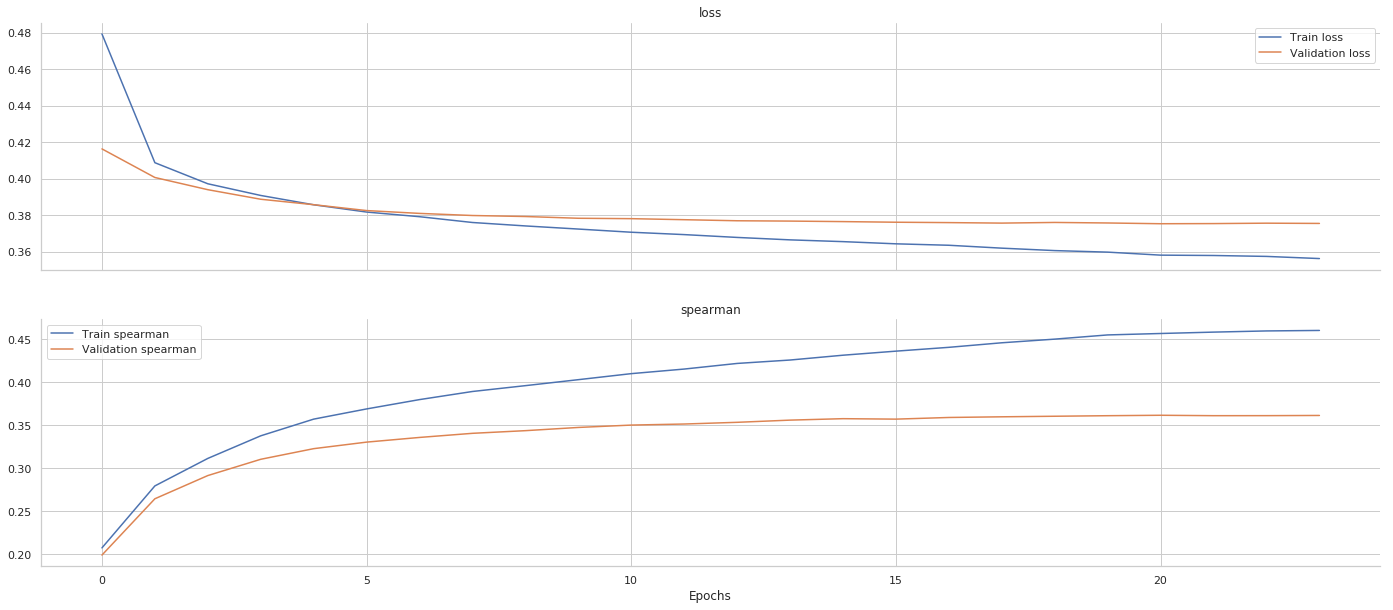

In [10]:
sns.set(style="whitegrid")
plot_metrics(history, metric_list=['loss', 'spearman'])

# Evaluation

In [11]:
preds_train = model.predict(X_train)
preds_val = model.predict(X_valid)

display(get_metrics(Y_train, preds_train, Y_valid, preds_val, target_cols))

,Label,Train,Validation
0,Averaged,0.460,0.361
1,question_asker_intent_understanding,0.413,0.383
2,question_body_critical,0.674,0.616
3,question_conversational,0.452,0.400
4,question_expect_short_answer,0.453,0.262
5,question_fact_seeking,0.513,0.338
6,question_has_commonly_accepted_answer,0.558,0.435
7,question_interestingness_others,0.374,0.372
8,question_interestingness_self,0.513,0.495
9,question_multi_intent,0.550,0.430


## By category

In [12]:
target_cols_preds = [col+'_pred' for col in target_cols]
for col in target_cols_preds:
    train[col] = 0
    validation[col] = 0
    
train[target_cols_preds] = preds_train
validation[target_cols_preds] = preds_val
    
display(get_metrics_category(train, validation, target_cols, target_cols_preds, 'category'))

,Label,Train (TECHNOLOGY),Validation (TECHNOLOGY),Train (SCIENCE),Validation (SCIENCE),Train (STACKOVERFLOW),Validation (STACKOVERFLOW),Train (LIFE_ARTS),Validation (LIFE_ARTS),Train (CULTURE),Validation (CULTURE)
0,Averaged,0.425,0.326,0.469,0.352,0.354,0.192,0.475,0.392,0.472,0.363


#### Save model weights and ecoders

In [13]:
model.save_weights(model_path)